In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

# Neural stuff

In [2]:
sigm = lambda x: 1/(1+np.exp(-x)) #función de activación sigmoide

In [3]:
class Layer:
       
    def __init__(self,NC,NN,ActFun,rate=1.1):  #Un learning rate más alto puede causar inestabilidad en el módelo mientras que uno muy bajo puede hacer que el módelo tarde mucho en aprender
        
        self.NC = NC #Numero de neuronas de la capa anterior
        self.NN = NN #Numero de neuronas de la capa actual
        self.ActFunc = ActFun #Función de activación
        self.rate = rate #Learning rate
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN))
        self.b = np.random.uniform( -10.,10.,(1,self.NN))
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

In [4]:
#Arquitectura de la red neuronal
def GetBrain():
    l0 = Layer(1,5,sigm)
    l1 = Layer(5,1,sigm)
    Brain = [l0,l1]
    #Puede llegar a funcionar con menos neuronas, por otro lado aumnetar el número de neuronas puede hacer que el módelo tarde más en entrenar 
    # sin que esto signifique que el módelo sea mejor pues estariamos sobreestimando el problema
    return Brain    

# Estructura del robot

In [5]:
class Robot:    
    def __init__(self, dt, Layers, Id=0):        
        self.Id = Id # Identificador del robot
        self.dt = dt # Paso de tiempo               
        self.r = np.random.uniform([0.,0.]) # Posición inicial
        theta = 0. 
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)]) # Velocidad inicial, en este caso solo trabajaremos con la componente x        
       
        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        self.Steps = 0
        self.Layers = Layers # Red neuronal del robot (Brain)
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
        self.r += self.v*self.dt # Euler integration (Metodos 2)

    def Reset(self):
    # Cada generación regreamos el robot al origin
    # Y volvemos a estimar su fitness
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    
        
    def SetFitness(self):
        self.Fitness = 1/(self.Steps + 1) #Función de aptitud    

    def BrainActivation(self,x,threshold=0.7): 
        # El umbral (threshold) cerebral es a tu gusto!
        # cercano a 1 es exigente
        # cercano a 0 es sindrome de down
        
        # Forward pass - la infomación fluye por el modelo hacia adelante
        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
        
        self.Activation = np.round(output,4)
    
        # Si el resultado es mayor al umbral cambiamos de dirección y la función de aptitud se mantiene igual
        if self.Activation[0] > threshold:
            self.v = -self.v
        else:
            self.Steps += 1 # Si la activación no es muy alta reducimos el valor de la función de aptitud
    
        return self.Activation
    
    # Aca mutamos (cambiar de parametros) para poder "aprender"
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    
    # Devolvemos la red neuronal ya entrenada
    def GetBrain(self):
        return self.Layers

In [6]:
def GetRobots(N,dt): #Generar robots y agregarlos a una lista   
    Robots = []

    for i in range(N):        
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

In [7]:
def GetPlot(): #Generar la figura donde se graficará l
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.) 
    return ax,ax1

# Time evolution

In [8]:
def TimeEvolution(Robots,e,Plot=True):
    for it in range(t.shape[0]):
        if Plot:
            clear_output(wait=True)
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
            ax.set_title('t = {:.3f}, simulación N° {:.0f}'.format(t[it], e))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            p.Evolution()      
            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            #Aumentamos los pasos para el fitness si el robot se encuentra en la region deseada
            if  -0.9 < p.GetR()[0] < 0.9:
                  p.Steps += 1         
                
            if Plot and i < 5: # Solo graficamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
                
        # Graficamos la activaciones de los primeros 5        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

# Algoritmo evolutivo

In [9]:
# Definimos la rutina de entrenamiento de la red neuronal
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):    
# Porcentaje de robots elegidos en cada epoca
    N = int(0.7*len(Robots))

    if len(Robots) == 1: #Si solo estamos graficando el mejor robot N = 1
        N = 1
    
    FitVector = np.array([])   
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):      
        # Reiniciamos y mutamos los pesos de cada robot
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar
        
        # Actualizamos fitness de cada robot
        for i,p in enumerate(Robots):
            p.SetFitness()
        
        #Rutina de ordenar los bots del más apto al menos apto
        scores = [(p.Fitness,p) for p in Robots]
        scores.sort(key = lambda x: x[0], reverse = False)
        Temp = [r[1] for i,r in enumerate(scores) if i < N]

        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(Temp[j])
        
        # Guardamos el mejor fitness junto con  mejor robot            
        best_fitness = scores[0][0]
        best_bot = scores[0][1] 
        FitVector = np.append(FitVector,best_fitness)
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)                
        print('Last Fitness:', FitVector[-1])        
        
        if Plot:            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.75,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)        
            ax.legend(loc=0)            
            plt.show()            
            time.sleep(0.01)    
        
    return best_bot, FitVector

In [10]:
dt = 0.1
t = np.arange(0.,5.,dt)
Robots = GetRobots(200,dt)

Epoch: 199
Last Fitness: 0.005128205128205128


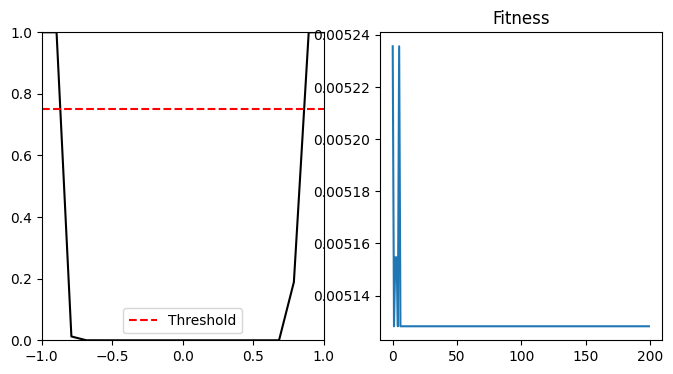

In [11]:
Best, FitVector = Genetic(Robots,epochs=200,Plot=True,Plottime=False) # Apagar Plottime para el entrenamiento

In [12]:
Genetic(Robots,epochs=5,Plot=False,Plottime=True) # Apagar Plottime para el entrenamiento

Epoch: 0
Last Fitness: 0.005128205128205128


(<__main__.Robot at 0x28c73eba710>, array([0.00512821]))

# Testeo mejor robot

In [13]:
Best_brain = Best.GetBrain() #Obtenemos la mejor red neuronal
dt = 0.1
t = np.arange(0.,15.,dt)

In [14]:
def GetBestRobots(Brain): 
    Best_robot = []
    Best_robot.append(Robot(dt,Brain))
        
    return Best_robot

In [15]:
Best_robot = GetBestRobots(Best_brain) #Creamos el mejor robot con el mejor cerebro

In [16]:
#Pesos de la mejor red neuronal
W_01 = Best_brain[0].W
b_01 = Best_brain[0].b
print("Pesos de la capa oculta:",W_01)
print("Bias de la capa oculta:",b_01)

Pesos de la capa oculta: [[ 7.08510815 27.3041792   3.76144978 -1.1914825  28.85271648]]
Bias de la capa oculta: [[ 13.29946602 -21.59468732  -1.82363729   7.69719881  24.16325737]]


In [17]:
W_10 = Best_brain[1].W
b_10 = Best_brain[1].b
print("Pesos de la capa salida:",W_10)
print("Bias de la capa salida:",b_10)


Pesos de la capa salida: [[-17.23385658]
 [ 30.37105602]
 [ -8.29922106]
 [ 19.86419311]
 [-28.54516777]]
Bias de la capa salida: [[15.88585397]]


In [18]:
Genetic(Best_robot,epochs=5,Plot=False,Plottime=True)

KeyboardInterrupt: 